## Objective

The objective is to identify the ATLAS activities with low CPU efficiency or low success rates and provide recommendations to optimise the workflows and to minimise expensive failures. It is considered acceptable to analyse only the last three months of data.

## Introduction

It is well known that inefficiencies are of two kinds:
* Wallclock time spent on failed jobs. It is measured by calculating the fraction of wallclock time used by ATLAS jobs which fail. It can be expressed as a failure rate as a function of the job wallclock time.
* Wallclock time not spent on computations. It is measured as the ratio between the CPU time and the wallclock time (times the number of job slots) and typically it depends on the amount of time spent in I/O operations, or in the case of multi-core jobs, on the time spent using a single process (e.g. internal merging).

Possible optimisations include:

* increase job length to decrease the impact of low-efficiency initialisation or merging phases
* decrease job length to decrease the loss of wall-clock time due to the failure of long jobs
* ...

Optimal CPU efficiencies may be determined experimentally by looking at the best CPU efficiencies achieved by site. The assumption is that the best ATLAS sites show performances which are very close to the maximum achievable today. On the other hand, the theoretical maximum could well be higher and achievable only after applying some optimisations.

## Analysis outline

Determine from data the failure rate as a function of the processing type and the wallclock time. From ES, use these fields:
1. processing type
1. transformation (essential to tell apart derivations from merge!)
1. ATLAS software version
1. wallclock time
1. job status
1. CPU type
1. JEDI task ID
1. JEDI task name
1. reqid
1. TODO: MC vs data (it can be derived from inputfileproject, with the caveat that sometimes it's undefined)
1. TODO: AMI tag (it can be obtained by parsing the task name)
1. exit codes (see below)
1. site
1. job submission time

Calculate the fraction of wallclock time wasted on failed jobs by processing type and identify the types responsible for the largest inefficiency.

For those, determine the distribution of the error codes to identify the most common causes.

Refine the analysis by looking for correlations between error code and wallclock time. For example, a common error cause that causes jobs to abort just after starting is much less important than an error cause that affects jobs after they ran for a long time.

*TODO*: understand how job retries work (failedattempt).

It will be interesting to look also into Stagein, Execution and Stageout times (Ilija's suggestion).

### Error codes
* brokerageerrorcode: unknown. Almost always zero. **It can be ignored**
* superrorcode: unknown. Always zero. **It can be ignored**
* ddmerrorcode: error from DDM. It is zero 99.5% of times, but still to be considered
* taskbuffererrorcode: meaning unknown (to me). Failures are very rare.
* jobdispatcherrorcode: error from Panda, implying that the job cannot be brokered. Examples: job recovery failed (101), lost heartbeat (100)
* **piloterrorcode**: error from the pilot. It can be zero even if the job fails, if the failure is in the payload
* **transexitcode**: error from transformation. It can be non-zero even if exeerrorcode is zero
* exeerrorcode: error from the executable. Sometimes 0 is associated to an error message (exeerrordiag not OK)

It is appropriate to aggregate with respect to ddmerrorcode, jobdispatcherrorcode, piloterrorcode, transexitcode and exeerrorcode. The most important codes are piloterrorcode and transexitcode.

There is a negligible fraction of jobs whose status is "failed" even if all exit codes are zero.

## Main error code values

## ddmerrorcode
* 200: various errors:
  * failed to lock semaphore for job cloning
  * could not get GUID/LFN/... from pilot XML
  * could not add files to DDM...
  * wrong file status in source database
  
## jobdispatchererrorcode
* 100: lost heartbeat
* 101: job recovery failed

## taskbuffererrorcode
* 113: merge job failed
* 101: transfer timeout
* 123: closed to retry unprocessed event ranges
* 114: maximum attempts reached for Event Service

## piloterrorcode
* 1008: LRMS error: (-1) Job finished with unknown exit code
* 1201: job killed by signal 15
* 1137: put error
* 1099: Get error: staging input file failed
* 1218: Exception caught in RunJobEvent: name 'runCommandList' is not defiled
* 1104: could not figure out destination path
* 1150: pilot has decided to kill lopping job
* 1213: reached maximum batch system time limit
* 1221: file already exist in the destination
* 1098: no space left on device
* 1152: copy command timed out

## transexitcode
* 127: ?
* 2: ?
* 1: ?
* 10: ?
* 251: ?
* 143: ?

## Setup

In [1]:
import re
import csv
import math
import datetime
import numpy as np
import IPython
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pandas as pd
import scipy.integrate as integrate
from elasticsearch import Elasticsearch, helpers

from __future__ import division

np.set_printoptions(threshold=np.inf)
np.seterr(divide='ignore')

%matplotlib inline

In [16]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

In [17]:
indices = es.cat.indices(index="jobs_archive_*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']

In [18]:
def time_filter(indices, days=0, until=0):
    if days == 0:
        return ["jobs_archive_*"]
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        day = re.sub(r'jobs_archive_', '', i).rstrip()
        try:
            day = datetime.datetime.strptime(day, datefmt).date()
            diff = today - day
            if until <= diff.days < days + until:
                filtered.append(i.rstrip())
        except:
            continue
    return filtered

In [132]:
# Change second argument to use a different time range for ES queries
ind = time_filter(indices, 30, 120)
ind = ','.join(ind)
print ind

jobs_archive_2016-08-28,jobs_archive_2016-08-29,jobs_archive_2016-08-30,jobs_archive_2016-08-31,jobs_archive_2016-09-01,jobs_archive_2016-09-02,jobs_archive_2016-09-03,jobs_archive_2016-09-04,jobs_archive_2016-09-05,jobs_archive_2016-09-06,jobs_archive_2016-09-07,jobs_archive_2016-09-08,jobs_archive_2016-09-09,jobs_archive_2016-09-10,jobs_archive_2016-09-11,jobs_archive_2016-09-12,jobs_archive_2016-09-13,jobs_archive_2016-09-14,jobs_archive_2016-09-15,jobs_archive_2016-09-16,jobs_archive_2016-09-17,jobs_archive_2016-09-18,jobs_archive_2016-09-19,jobs_archive_2016-09-20,jobs_archive_2016-09-21,jobs_archive_2016-09-22,jobs_archive_2016-09-23,jobs_archive_2016-09-24,jobs_archive_2016-09-25,jobs_archive_2016-09-26


In [133]:
s = {
    "size": 0,
    "query": {
        "bool": {
            "filter": [
                {"range": {"wall_time": {"ge": 0}}},
                {"match": {"prodsourcelabel": "managed"}},
                {"exists": {"field": "actualcorecount"}}
            ],
            "must_not": {
                "prefix": {"processingtype": "ganga"}
            }
        }
    },
    "aggs": {
        "ptypes": {
            "terms": {
                "field": "processingtype",
                "size": 1000
            },
            "aggs": {
                "trans": {
                    "terms": {
                        "field": "transformation",
                        "size": 1000
                    },
                    "aggs": {
                        "wgroup": {
                            "terms": {
                                "field": "workinggroup",
                                "size": 1000
                            },
                            "aggs": {
                                "reqid": {
                                    "terms": {
                                        "field": "reqid",
                                        "size": 1000
                                    },
                                    "aggs": {
                                        "jstatus": {
                                            "terms": {
                                                "field": "jobstatus",
                                                "size": 1000
                                            },
                                            "aggs": {
                                                "atlrel": {
                                                    "terms": {
                                                        "field": "atlasrelease",
                                                        "size": 1000
                                                    },
                                                    "aggs": {
                                                        "site": {
                                                            "terms": {
                                                                "field": "computingsite",
                                                                "size": 1000
                                                            },
                                                            "aggs": {
                                                                "cputype": {
                                                                    "terms": {
                                                                        "field": "cpuconsumptionunit",
                                                                        "size": 1000
                                                                    },
                                                                    "aggs": {
                                                                        "ddmerror": {
                                                                            "terms": {
                                                                                "field": "ddmerrorcode",
                                                                                "size": 1000
                                                                            },
                                                                            "aggs": {
                                                                                "jobdispatch": {
                                                                                    "terms": {
                                                                                        "field": "jobdispatchererrorcode",
                                                                                        "size": 1000
                                                                                    },
                                                                                    "aggs": {
                                                                                        "piloterror": {
                                                                                            "terms": {
                                                                                                "field": "piloterrorcode",
                                                                                                "size": 1000
                                                                                            },
                                                                                            "aggs": {
                                                                                                "transexit": {
                                                                                                    "terms": {
                                                                                                        "field": "transexitcode",
                                                                                                        "missing": "-1",
                                                                                                        "size": 1000
                                                                                                    },
                                                                                                    "aggs": {
                                                                                                        "exeerror": {
                                                                                                            "terms": {
                                                                                                                "field": "exeerrorcode",
                                                                                                                "size": 1000
                                                                                                            },
                                                                                                            "aggs": {
                                                                                                                "jtask": {
                                                                                                                    "terms": {
                                                                                                                        "field": "jeditaskid",
                                                                                                                        "size": 100000
                                                                                                                    },
                                                                                                                    "aggs": {
                                                                                                                        "4": {
                                                                                                                            "stats": {
                                                                                                                                "script": {
                                                                                                                                    "inline": "doc['wall_time'].value * doc['actualcorecount']",
                                                                                                                                    "lang": "expression"
                                                                                                                                }
                                                                                                                            }
                                                                                                                        },
                                                                                                                        "6": {
                                                                                                                            "stats": {
                                                                                                                                "field": "cpuconsumptiontime"
                                                                                                                            }
                                                                                                                        },
                                                                                                                        "5": {
                                                                                                                            "avg": {
                                                                                                                                "field": "actualcorecount"
                                                                                                                            }
                                                                                                                        },
                                                                                                                        "7": {
                                                                                                                            "sum": {
                                                                                                                                "field": "nevents"
                                                                                                                            }
                                                                                                                        }
                                                                                                                    }
                                                                                                                }
                                                                                                            }
                                                                                                        }
                                                                                                    }
                                                                                                }
                                                                                            }
                                                                                        }
                                                                                    }
                                                                                }
                                                                            }
                                                                        }
                                                                    }
                                                                }
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }
}
res = es.search(index=ind, body=s, request_timeout=12000)

In [94]:
output_file = 'task_eff_5.csv'

In [95]:
with open(output_file, 'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    buckets1 = res['aggregations']['ptypes']['buckets']
    for b1 in buckets1:
        ptype = b1['key']
        buckets2 = b1['trans']['buckets']
        for b2 in buckets2:
            trans = b2['key']        
            buckets3 = b2['wgroup']['buckets']
            for b3 in buckets3:
                wgroup = b3['key']
                buckets4 = b3['reqid']['buckets']
                for b4 in buckets4:
                    reqid = b4['key']
                    buckets5 = b4['jstatus']['buckets']
                    for b5 in buckets5:
                        jstatus = b5['key']
                        buckets6 = b5['atlrel']['buckets']
                        for b6 in buckets6:
                            atlrel = b6['key']
                            buckets7 = b6['site']['buckets']
                            for b7 in buckets7:
                                site = b7['key']
                                buckets8 = b7['cputype']['buckets']
                                for b8 in buckets8:
                                    cputype = b8['key']
                                    buckets9 = b8['ddmerror']['buckets']
                                    for b9 in buckets9:
                                        ddmerror = b9['key']
                                        buckets10 = b9['jobdispatch']['buckets']
                                        for b10 in buckets10:
                                            jobdispatcherror = b10['key']
                                            buckets11 = b10['piloterror']['buckets']
                                            for b11 in buckets11:
                                                piloterror = b11['key']
                                                buckets12 = b11['transexit']['buckets']
                                                for b12 in buckets12:
                                                    transexit = b12['key']
                                                    buckets13 = b12['exeerror']['buckets']
                                                    for b13 in buckets13:
                                                        exeerror = b13['key']
                                                        buckets14 = b13['jtask']['buckets']
                                                        for b14 in buckets14:
                                                            njobs = b14['doc_count']
                                                            jtask = b14['key']
                                                            writer.writerow([
                                                                jtask,
                                                                ptype,
                                                                trans,
                                                                reqid,
                                                                wgroup,
                                                                jstatus,
                                                                atlrel,
                                                                site,
                                                                cputype,
                                                                ddmerror,
                                                                jobdispatcherror,
                                                                piloterror,
                                                                transexit,
                                                                exeerror,
                                                                njobs,
                                                                b14['4']['avg'],
                                                                b14['4']['sum'],
                                                                b14['6']['avg'],
                                                                b14['6']['sum'],
                                                                b14['5']['value'],
                                                                b14['7']['value']
                                                            ])

Note: I had trouble with the generated CSV files due to them being truncated. Moreover, note that there is a nan value for njobs, which should be understood.

## Data analysis

In [225]:
input_file = 'task_eff_ac3.csv'
df = pd.read_csv(input_file, dtype={'cpu_n': 'float', 'cores': 'float'}, names=['jeditaskid', 'processingtype', 'trans', 'reqid', 'wgroup', 'jobstatus', 'atlrel', 'site',
                                                               'cputype', 'ddmerr', 'jderr', 'pilerr', 'transerr',
                                                               'exeerr', 'njobs', 'wc_avg', 'wc', 'cores', 'jevts'])
#df = pd.read_csv(input_file, dtype={'cpu_n': 'float', 'cores': 'float'}, names=['jeditaskid', 'processingtype', 'trans', 'reqid', 'wgroup', 'jobstatus', 'atlrel', 'site',
#                                                               'cputype', 'ddmerr', 'jderr', 'pilerr', 'transerr',
#                                                               'exeerr', 'njobs', 'wc_avg', 'wc', 'cpu_avg', 'cpu', 'cores', 'jevts'])

In [33]:
df = df[(df.processingtype != 'validation')].copy()

### WC contribution for each processingtype

In [3]:
grouped = df.groupby(['processingtype'], as_index=False)
r = grouped['wc'].agg('sum')
tot_wc = r['wc'].sum()
r['wc'] = r['wc'].divide(tot_wc)
print r

   processingtype            wc
0           digit  6.678737e-09
1      eventIndex  4.570575e-04
2           evgen  1.837992e-01
3           merge  1.154056e-01
4         overlay  7.547658e-04
5            pile  1.326467e-01
6          pmerge  4.946694e-03
7           recon  8.692439e-03
8    reprocessing  5.828237e-02
9           simul  4.233389e-01
10           skim  2.111894e-04
11         urgent  1.314845e-04
12     validation  7.133352e-02


In [54]:
grouped = df[df.jobstatus == 'finished'].groupby(['processingtype'], as_index=False)
r = grouped['wc'].agg('sum')
tot_wc = r['wc'].sum()
r['wc'] = r['wc'].divide(tot_wc)
print r

   processingtype        wc
0      eventIndex  0.000497
1           evgen  0.196563
2           merge  0.115312
3         overlay  0.000505
4            pile  0.148950
5          pmerge  0.004653
6           recon  0.008833
7    reprocessing  0.052520
8           simul  0.466010
9            skim  0.000226
10         urgent  0.000155
11     validation  0.005777


In [55]:
a = df[df.jobstatus == 'finished'].sort_values('wc_avg', ascending=False)
print a[:1]

         jeditaskid processingtype      trans  reqid   wgroup jobstatus  \
2402485    10105511          simul  Sim_tf.py  10001  AP_EXOT  finished   

               atlrel          site                                   cputype  \
2402485  Atlas-19.2.4  SiGNET_MCORE  s+AMD Opteron(TM) Processor 6274 2048 KB   

         ddmerr  jderr  pilerr  transerr  exeerr  njobs     wc_avg         wc  \
2402485       0      0       0        -1       0      1  8394880.0  8394880.0   

         cores   jevts  
2402485    8.0  1000.0  


In [4]:
# This function plots a histogram of df[var] with custom axis labels and printing avg and std

def make_plot(df, var, w_var=None, bins=100, rg=None, log=False, xlab=None, ylab=None, xunit=None, title=''):
    fig = plt.figure(figsize=(7,5))
    sp = plt.subplot(1, 1, 1)
    if w_var is None:
        mu = np.mean(df[var])
        sigma = np.std(df[var])
        if rg == 'auto':
            rg = [0., min(mu*11., mu+sigma*10.)]
        x = plt.hist(df[var], bins=bins, log=log, range=rg)
    else:
        mu = np.average(df[var], weights=df[w_var])
        sigma = math.sqrt(np.average((df[var] - mu)**2, weights=df[w_var]))
        if rg == 'auto':
            rg = [0., min(mu*10., mu+sigma*10.)]   # at least 10 times the average or at least 10 times the aver
        x = plt.hist(df[var], bins=bins, weights=df[w_var], log=log, range=rg)
    stats = r'$\mu=%.3f\pm%.3f\ %s$' % (mu, sigma, xunit)
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    if log:
        if title: plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.9, title)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stats)
    else:
        plt.text(t_x(.4), t_y(.7), stats)
        plt.text(t_x(.4), t_y(.9), title)
    plt.xlabel(xlab + '(' + xunit + ')')
    plt.ylabel(ylab)
    return x

In [5]:
def histo2fun(histo):
    """
    Converts a matplotlib histogram into a function
    """
    n, bins, _ = histo
    def f(x):
        if x < bins[0]: return 0.
        if x > bins[-1]: return 0.
        for i in range(len(n)):
            if bins[i+1] > x: return n[i]
    return f

## First data exploration

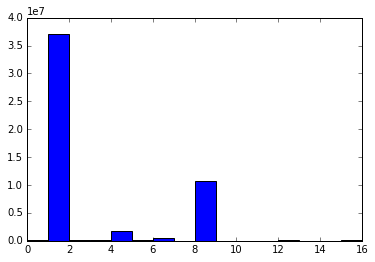

In [6]:
_ = plt.hist(df['cores'], weights=df['njobs'], bins=16, range=[0., 16.], log=False)
#_ = plt.hist(df['cores'], bins=16, range=[0., 16.], log=False)

I noted that requiring a value for transexitcode cuts down significantly the number of jobs, as only 22% of jobs is retained! The numbers above have been validated with Kibana.

## Filters

In [217]:
# General filter, use to select only a particular category of jobs
#df2 = df[(df.processingtype == 'merge') & (df.trans == 'Reco_tf.py')].copy()
df2 = df[(df.processingtype == 'pile')].copy()
#df2 = df.copy()

# Filter only for failed jobs, use to select only a particular failure mode
df3 = df2[(df2.jderr == 100)].copy()
#df3 = df2.copy()

The following code counts the count number for each transformation for merge jobs; it's used to assess the fraction of derivations (Reco_tf.py).

In [173]:
df[df.processingtype == 'merge']['trans'].value_counts()

Reco_tf.py            900284
AODMerge_tf.py         40195
HITSMerge_tf.py        16567
Merging_trf.py         10246
Reco_trf.py             2449
NTUPMerge_tf.py         2397
HLTHistMerge_tf.py      2151
FilterHit_tf.py         1857
FilterHit_trf.py         623
HISTMerge_tf.py           18
Name: trans, dtype: int64

This code sorts sites according to their contribution to the wasted wallclock time for the error mode being considered. It is useful to understand if particular sites account for a significant fraction of this error mode.

In [174]:
grouped = df3.groupby(['site'], as_index=False)
a = grouped.agg({'wc': 'sum'})
tot = a.wc.sum()
a.wc = a.wc / tot
a.sort_values('wc', ascending=False)[:10]

,site,wc
32,DESY-HH_Condor,0.159787
49,HU_ATLAS_Tier2_MCORE,0.089659
108,SFU-LCG2_MCORE,0.082956
42,GRIF-IRFU_MCORE,0.074137
78,INFN-T1_MCORE,0.038181
63,IN2P3-CC_MCORE_HIMEM,0.027791
76,INFN-T1,0.023577
89,MWT2_MCORE,0.022457
97,RAL-LCG2_MCORE,0.021745
8,BU_ATLAS_Tier2_MCORE,0.020322


This code calculates the fraction of failed jobs that failed with the specified error code, per site. It allows to see if that error code is the dominant one at the site.

In [175]:
grouped = df2.groupby(['site'], as_index=True)['njobs', 'pilerr', 'jobstatus']
def f(g):
    err = g[g.pilerr == 1213]['njobs'].sum()
    tot = g[g.jobstatus == 'failed']['njobs'].sum()
    if tot > 0:
        return err / tot
    else:
        return 0.
a = grouped.apply(f)
a.sort_values(ascending=False)

site
UKI-SOUTHGRID-SUSX_SL6         0.151515
CERN-PROD_CLOUD                0.039672
IN2P3-CC                       0.028444
UKI-SOUTHGRID-SUSX_MCORE       0.021053
LRZ-LMU                        0.018888
CERN-PROD_MCORE                0.014286
ROMANIA07_MCORE                0.009208
IHEP_MCORE                     0.008651
UKI-NORTHGRID-MAN-HEP_VAC      0.007530
BU_ATLAS_Tier2_SL6             0.007333
CERN-PROD_T0_8MCORE            0.007018
CPPM_MCORE                     0.006897
CERN-PROD_T0_4MCORE            0.006663
AGLT2_MCORE                    0.004769
UNI-FREIBURG_MCORE             0.004695
CERN-PROD                      0.004580
LRZ-LMU_CLOUD                  0.004464
INFN-MILANO-ATLASC_MCORE       0.004219
CERN-PROD_SHORT                0.004186
UKI-NORTHGRID-MAN-HEP_MCORE    0.004174
INFN-NAPOLI-RECAS_MCORE        0.003891
NIKHEF-ELPROD_MCORE            0.003889
INFN-FRASCATI_MCORE            0.003779
pic_MCORE                      0.003433
MPPMU_MCORE                    0.00

In [218]:
df_failed = df3[df3.jobstatus == 'failed'].copy()
df_ok = df2[df2.jobstatus == 'finished'].copy()

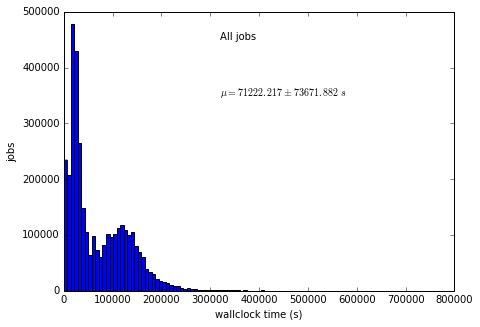

In [219]:
tot = make_plot(df2, 'wc_avg', w_var='njobs', bins=100, rg=[0., 720000.], xlab='wallclock time ', log=False, xunit='s', ylab='jobs', title='All jobs')
f_tot = histo2fun(tot)

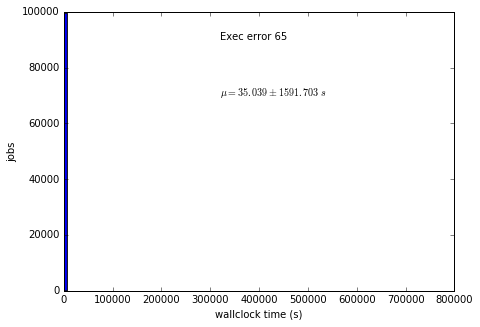

In [223]:
fail = make_plot(df_failed, 'cpu_avg', w_var='njobs', bins=100, rg=[0., 720000.], xlab='wallclock time ', log=False, xunit='s', ylab='jobs', title='Exec error 65')
f_fail = histo2fun(fail)

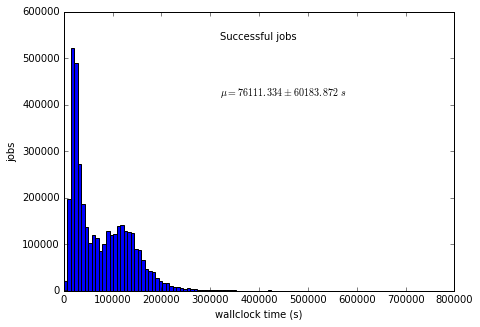

In [187]:
ok = make_plot(df_ok, 'wc_avg', w_var='njobs', bins=100, rg=[0., 720000.], xlab='wallclock time ', log=False, xunit='s', ylab='jobs', title='Successful jobs')
f_ok = histo2fun(ok)

Dividing bin by bin the first histogram by the sum of the two, produces the failure rate as a function of the wallclock time.

In [17]:
def f_rate(x):
    if f_fail(x) + f_ok(x) != 0.:
        return f_fail(x) / (f_fail(x) + f_ok(x))
    else:
        return 1.

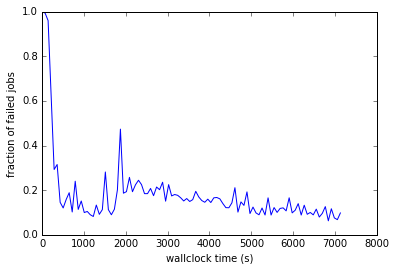

In [22]:
x = np.arange(0., 7200., 72.)
plt.plot(x, [f_rate(i) for i in x])
plt.xlabel('wallclock time (s)')
plt.ylabel('fraction of failed jobs')

In [58]:
np.seterr(all='ignore')
rate = np.divide(fail[0], (fail[0] + ok[0]))

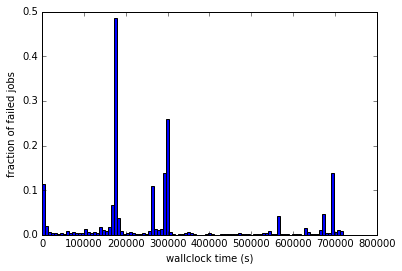

In [59]:
plt.bar(fail[1][:-1], rate,width=7200.)
plt.xlabel('wallclock time (s)')
plt.ylabel('fraction of failed jobs')

It is expected that a high fraction of short jobs are failures, because many jobs fail at the beginning, and a high fraction of long jobs are failures, because they can be stuck (TO BE CONFIRMED BY AN ANALYSIS OF ERROR CODES).

The plot above is *not* the probability of a job of length T to fail! TODO: calculate mathematically and understand how to derive it from data.

Let $P_F(T)$ be the probability density for a job of infinite length to fail at time $T$ and $D(T)$ the probability density for a job to have a duration $T$ assuming it will not fail. The number of jobs which fail between $T$ and $T+\Delta T$ is:

$$\Delta C_F = P_F(T)\Delta T\int_{T}^{+\infty}D(t)dt\equiv D_F(T)\Delta T$$

while the number of jobs which succeed and finish between $T$ and $T+\Delta T$ is:

$$\Delta C_S = D(T)\Delta T\left(1-\int_{0}^{T}P_F(T)\right)dt\equiv D_S(T)\Delta T$$

In order to calculate $P_F(T)$, an iterative approach could be considered. Initially we can assume that $D(T)$ is proportional to the distribution of successful jobs, $D_S(T)$, which is known from data. Therefore:

$$P_F(T)=\frac{D_F(T)}{K\int_{T}^{+\infty}D_S(t)dt}$$

$K$ can be chosen such that $P_F(T)$ is normalised to 1.

Subsequently, our first estimate of $P_F(T)$ can be used to better calculate $D_S(T)$ and the result can be used to recalculate $P_F(T)$. The procedure can be repeated until it converges.

BUG: this reasoning does not take into account that a job may last for longer than normal because it failed!!!

What shape do we expect for $P_F(T)$? In a very simplistic model, assume that all jobs have infinite lifetime. A job can randomly fail at any time, which leads to an exponential distribution for $P_F(T)$. In this case:

$$\Delta C_F=\frac{N}{\alpha}e^{-\frac{1}{T}}\Delta T$$

and

$$\Delta C_S=0$$ for any finite value of T

In [60]:
def p_f(d_f, k, d_s):
    def f(t):
        d = integrate.quad(d_s, t, np.inf)[0]
        if d > 0.:
            return d_f(t) / (k * d)
        else:
            return 0.
    return f

In [61]:
prob_f = p_f(f_fail, 1., f_ok)

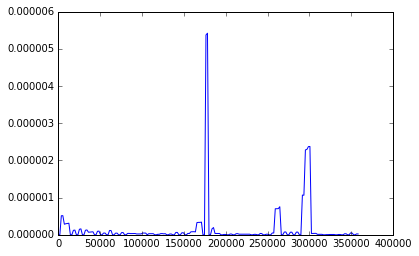

In [64]:
x = np.arange(0., 360000., 1800.)
plt.plot(x, [prob_f(i) for i in x])

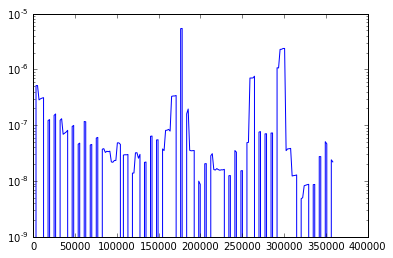

In [65]:
plt.plot(x, [prob_f(i) for i in x])
plt.yscale('log')

The probability of failing has significant spikes for 2 days, 3 days and ~22K seconds. Remember that wallclock time is multiplied by actualcorecount, so these spikes correspond to single core jobs, which are the vast majority in this sample. To be verified that these spikes correspond to jobs killed by the batch system for exceeding queue time limits.

## Overall failure rates

See what are the failure rates for the different processing types.

In [105]:
n_failed = df[df.jobstatus == 'failed']['wc'].sum()
n_finished = df[df.jobstatus == 'finished']['wc'].sum()
print 'Failure rates by wallclock time'
print 'Overall failure rate: %.3f' % (n_failed / (n_failed + n_finished))
ptypes = df.processingtype.unique()
for p in ptypes:
    n_failed = df[(df.processingtype == p) & (df.jobstatus == 'failed')]['wc'].sum()
    n_finished = df[(df.processingtype == p) & (df.jobstatus == 'finished')]['wc'].sum()
    print 'Failure rate for %s: %.3f' % (p, n_failed / (n_failed + n_finished))
    #print '%s: %f\t%f' % (p, n_failed, n_finished)

Failure rates by wallclock time
Overall failure rate: 0.118
Failure rate for validation: 0.327
Failure rate for simul: 0.097
Failure rate for merge: 0.154
Failure rate for pile: 0.075
Failure rate for reprocessing: 0.250
Failure rate for evgen: 0.121
Failure rate for pmerge: 0.223
Failure rate for recon: 0.158
Failure rate for eventIndex: 0.108
Failure rate for urgent: 0.028
Failure rate for skim: 0.122
Failure rate for overlay: 0.448
Failure rate for digit: 1.000


The numbers above indicate that job failures impact mostly simul, evgen, merge and reprocessing. pile job are in a good shape.

**I have checked that removing the requirement for actualcorecount to exist does not significantly change the failure rates.**

### Error code breakdown analysis

In [226]:
def error_rate(df, ptype, trans, err, metric, status='failed'):
    fail = df[(df.processingtype == ptype) & (df.jobstatus == status) & (df[err] > 0)][metric].sum()
    ok = df[(df.processingtype == ptype) & (df.jobstatus == status) & (df[err] <= 0)][metric].sum()
    return (ok, fail, fail / (ok + fail))

In [227]:
def error_rate(df, ptype, trans, err, metric, status='failed'):
    fail = df[(df.processingtype == ptype) & (df.trans == trans) & (df.jobstatus == status) & (df[err] > 0)][metric].sum()
    ok = df[(df.processingtype == ptype) & (df.trans == trans) & (df.jobstatus == status) & (df[err] <= 0)][metric].sum()
    return (ok, fail, fail / (ok + fail))

In [234]:
def error_rate(df, ptype, trans, err, metric, status='failed'):
    if ptype:
        if trans:
            fail = df[(df.processingtype == ptype) & (df.trans == trans) & (df.jobstatus == status) & (df[err] > 0)][metric].sum()
            ok = df[(df.processingtype == ptype) & (df.trans == trans) & (df.jobstatus == status) & (df[err] <= 0)][metric].sum()
        else:
            fail = df[(df.processingtype == ptype) & (df.jobstatus == status) & (df[err] > 0)][metric].sum()
            ok = df[(df.processingtype == ptype) & (df.jobstatus == status) & (df[err] <= 0)][metric].sum()
    else:
        fail = df[(df.jobstatus == status) & (df[err] > 0)][metric].sum()
        ok = df[(df.jobstatus == status) & (df[err] <= 0)][metric].sum()
        
            
    return (ok, fail, fail / (ok + fail))

In [235]:
# Change these parameters as appropriate
ptype = ''
#trans = 'Reco_tf.py'
trans = ''
metric = 'wc'

In [236]:
ddm_ok, ddm_err, ddm_eff = error_rate(df, ptype, trans, 'ddmerr', metric)
jd_ok, jd_err, jd_eff = error_rate(df, ptype, trans, 'jderr', metric)
pil_ok, pil_err, pil_eff = error_rate(df, ptype, trans, 'pilerr', metric)
trans_ok, trans_err, trans_eff = error_rate(df, ptype, trans, 'transerr', metric)
exe_ok, exe_err, exe_eff = error_rate(df, ptype, trans, 'exeerr', metric)

In [237]:
print 'Inefficiency measured as %s:' % metric
print 'DDM: %.2f' % ddm_eff
print 'Job dispatcher: %.2f' % jd_eff
print 'Pilot: %.2f' % pil_eff
print 'Transformation: %.2f' % trans_eff
print 'Executable: %.2f' % exe_eff

Inefficiency measured as wc:
DDM: 0.06
Job dispatcher: 0.19
Pilot: 0.42
Transformation: 0.03
Executable: 0.39


In [112]:
def main_errors(df, ptype, trans, err, metric, status='failed', limit=0.8, frac=0.2):
    """
    The most important error codes are listed, sorted by their contribution to the failure rate.
    Only the codes that cumulatively account for a fraction of the total failure rate less than 'limit' are considered.
    Moreover, error codes accounting for less than 'frac' times the most important error code are returned. The rationale
    is to keep only those error codes which are more worth to be investigated.
    """
    if ptype:
        if trans:
            tot = df[(df.processingtype == ptype) & (df.trans == trans) & (df.jobstatus == status) & (df[err] > 0)][metric].sum()
            grouped = df[(df.processingtype == ptype) & (df.trans == trans) & (df.jobstatus == status) & (df[err] > 0)].groupby(err)
        else:
            tot = df[(df.processingtype == ptype) & (df.jobstatus == status) & (df[err] > 0)][metric].sum()
            grouped = df[(df.processingtype == ptype) & (df.jobstatus == status) & (df[err] > 0)].groupby(err)
    else:
        tot = df[(df.jobstatus == status) & (df[err] > 0)][metric].sum()
        grouped = df[(df.jobstatus == status) & (df[err] > 0)].groupby(err)
        
    rates = grouped[metric].agg(np.sum).sort_values(ascending=False) / tot
    part = 0.
    first = True
    x0 = 0.
    for i, x in rates.iteritems():
        if first:
            x0 = x
            first = False
        if x > x0 * frac:
            print 'Error code: %s, fraction: %.2f, wallclock time: %e' % (i, x, x * tot)
        part += x
        if part >= limit: break

In [229]:
main_errors(df, ptype, trans, 'ddmerr', metric)

Error code: 200, fraction: 1.00, wallclock time: 1.680538e+10


In [230]:
main_errors(df, ptype, trans, 'jderr', metric)

Error code: 100, fraction: 0.97, wallclock time: 4.957366e+10


In [231]:
main_errors(df, ptype, trans, 'pilerr', metric)

Error code: 1201, fraction: 0.35, wallclock time: 3.866953e+10
Error code: 1137, fraction: 0.17, wallclock time: 1.859276e+10
Error code: 1213, fraction: 0.16, wallclock time: 1.821602e+10
Error code: 1150, fraction: 0.09, wallclock time: 1.047401e+10


In [232]:
main_errors(df, ptype, trans, 'transerr', metric)

Error code: 143, fraction: 0.31, wallclock time: 2.118065e+09
Error code: 240, fraction: 0.19, wallclock time: 1.335515e+09
Error code: 251, fraction: 0.18, wallclock time: 1.223835e+09
Error code: 252, fraction: 0.17, wallclock time: 1.135329e+09


In [233]:
main_errors(df, ptype, trans, 'exeerr', metric)

Error code: 65, fraction: 0.74, wallclock time: 7.782062e+10


## Summary of error code analysis

### simul

The main sources of error are pilot (0.49), executable (0.37) and job dispatcher (0.24).

The main pilot errors are 1201 (0.47), 1213 (0.17) and 1150 (0.16).

The main executable errors are 65 (0.58) and 68 (0.24).

The main job dispatcher errors are 100 (0.98).

In [40]:
fail = df[(df.processingtype == 'simul') & (df.jobstatus == 'failed') & ((df.pilerr == 1201) | (df.exeerr == 65) | (df.jderr == 100))]['wc'].sum()
ok = df[(df.processingtype == 'simul') & (df.jobstatus == 'finished')]['wc'].sum()
print fail, ok, fail / (fail + ok)

64058123021.0 898776692021.0 0.0665307506752


### evgen

The main sources of error are pilot (0.39), executable (0.33) and job dispatcher (0.28).

The main pilot errors are 1201 (0.47) and 1213 (0.34).

The main executable errors are 65 (0.98).

The main job dispatcher errors are 100 (0.99).

In [74]:
fail = df[(df.processingtype == 'evgen') & (df.jobstatus == 'failed') & ((df.pilerr == 1201) | (df.exeerr == 65) | (df.jderr == 100))]['wc'].sum()
ok = df[(df.processingtype == 'evgen') & (df.jobstatus == 'finished')]['wc'].sum()
print fail, ok, fail / (fail + ok)

42361850300.0 392472820572.0 0.0974205902557


### merge

The main sources of error are pilot (0.59), executable (0.14) and job dispatcher (0.10).

The main pilot errors are 1137 (0.33) and 1221 (0.14).

The main executable errors are 65 (0.78).

The main job dispatcher errors are 100 (0.90).

In [175]:
fail = df[(df.processingtype == 'merge') & (df.trans == 'Reco_tf.py') & (df.jobstatus == 'failed') & ((df.pilerr == 1137) | (df.exeerr == 65) | (df.jderr == 100))]['wc'].sum()
ok = df[(df.processingtype == 'merge') & (df.trans == 'Reco_tf.py') & (df.jobstatus == 'finished')]['wc'].sum()
print fail, ok, fail / (fail + ok)

16147422608.0 227200947731.0 0.0663551705134


### reprocessing

The main sources of error are executable (0.78) and pilot (0.14).

The main executable errors are 65 (0.93).

The main pilot errors are 1137 (0.20) and 1221 (0.19).

In [192]:
fail = df[(df.processingtype == 'reprocessing') & (df.jobstatus == 'failed') & ((df.pilerr == 1137) | (df.pilerr == 1221) | (df.exeerr == 65))]['wc'].sum()
ok = df[(df.processingtype == 'reprocessing') & (df.jobstatus == 'finished')]['wc'].sum()
print fail, ok, fail / (fail + ok)

27251856823.0 104865200026.0 0.206270541238


### pile

In [181]:
fail = df[(df.processingtype == 'pile') & (df.jobstatus == 'failed') & ((df.pilerr == 1104) | (df.pilerr == 1137) | (df.exeerr == 65) | (df.jderr == 100))]['wc'].sum()
ok = df[(df.processingtype == 'pile') & (df.jobstatus == 'finished')]['wc'].sum()
print fail, ok, fail / (fail + ok)

13962426737.0 297405800249.0 0.044842169261


## Summary of error types

In [238]:
fail = df[(df.jobstatus == 'failed') & ((df.jderr == 100) | (df.pilerr == 1201) | (df.exeerr == 65))]['wc'].sum()
ok = df[df.jobstatus == 'finished']['wc'].sum()
print fail, ok, fail / (fail + ok)

166063808790.0 1.99667905142e+12 0.0767838894977
